In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pandas.tseries.offsets import DateOffset
#from pandas_datareader import data
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime, timedelta

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
# Loading data
file_path = Path("../Datasets/1dayForward/algoData_S&P500_1dayForward.csv")
df = pd.read_csv(file_path)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)


In [3]:
# z-scores Features
zScoreFeatures = ['EMAShort_zscore', 'EMALong_zscore',  'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore',
                   'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', "upperBB_zscore", 
                  "2stdBB_zscore", "MACDline_zscore", 'MACDHistogram_zscore','MACDSignal_zscore' ]


# normal Features
normalFeatures = ['EMAShort_normal', 'EMALong_normal',  'RSIline_normal', 'MOMline_normal', 'ROCline_normal',
                   'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', "upperBB_normal", 
                  "2stdBB_normal", "MACDline_normal", 'MACDHistogram_normal','MACDSignal_normal' ]

In [4]:
# Separate the data into labels and features

# Separate the y variable, the labels
#y = df["Signal"].values.reshape(-1,1)
y = df['Signal']

# Separate the X variable, the features
#X = df[zScoreFeatures]
X = df[normalFeatures]

In [5]:
# Split data into training and test datasets

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2006-10-10 00:00:00-04:00


In [6]:
# Select the ending period for the training data with an offset of 145 months
training_end = X.index.min() + DateOffset(months=145)

# Display the training end date
print(training_end)

2018-11-10 00:00:00-04:00


In [7]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
#X_train.tail()

In [8]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
#X_test.head()

In [9]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)

In [10]:
# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [11]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)


In [12]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,
                    index=['Sell', 'Buy'],
                    columns=['Sell', 'Buy'])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [13]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Sell,Buy
Sell,183,272
Buy,195,348


Accuracy Score : 0.5320641282565131
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.40      0.44       455
         1.0       0.56      0.64      0.60       543

    accuracy                           0.53       998
   macro avg       0.52      0.52      0.52       998
weighted avg       0.53      0.53      0.53       998



In [14]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [15]:
# List the most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)
importances_sorted[:]

[(0.08493578802526522, 'MOMline_normal'),
 (0.08415621393735934, 'ROCline_normal'),
 (0.08313644551098445, 'RSIline_normal'),
 (0.07672871456527407, 'SMAline_normal'),
 (0.07639405519139006, 'MACDHistogram_normal'),
 (0.0763510887481128, 'MACDSignal_normal'),
 (0.07600494513532845, 'upperBB_normal'),
 (0.07586781325633588, 'MACDline_normal'),
 (0.07463999530279586, 'EMALong_normal'),
 (0.07427948577740992, '2stdBB_normal'),
 (0.07288325166807764, 'EMAShort_normal'),
 (0.07234254884233415, 'lowerBB_normal'),
 (0.07227965403933212, 'middleBB_normal')]

<AxesSubplot:xlabel='Date'>

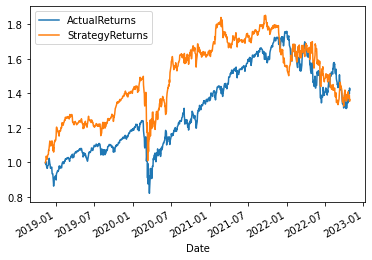

In [16]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = predictions

predictions_df['ActualReturns'] = df['ActualReturns']

# Add the strategy returns to the DataFrame
predictions_df['StrategyReturns'] = predictions_df['ActualReturns'] * predictions_df['Predicted']

# Plot the actual returns versus the strategy returns
(1 + predictions_df[["ActualReturns", "StrategyReturns"]]).cumprod().plot()